# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

# Описание данных

Данные геологоразведки трёх регионов находятся в файлах: 

/datasets/geo_data_0.csv

/datasets/geo_data_1.csv

/datasets/geo_data_2.csv

**id** — уникальный идентификатор скважины;

**f0, f1, f2** — три признака точек (неважно, что они означают, но сами признаки значимы);
product — объём запасов в скважине (тыс. баррелей).

## Загрузка и подготовка данных

In [1]:
pip install pandas-profiling



     |████████████████████████████████| 324 kB 1.1 MB/s eta 0:00:01     |███████                         | 71 kB 1.2 MB/s eta 0:00:01



     |████████████████████████████████| 357 kB 18.6 MB/s eta 0:00:01



     |████████████████████████████████| 296 kB 19.2 MB/s eta 0:00:01







     |████████████████████████████████| 460 kB 44.8 MB/s eta 0:00:01




     |████████████████████████████████| 679 kB 76.0 MB/s eta 0:00:01











     |████████████████████████████████| 102 kB 70.1 MB/s eta 0:00:01










     |████████████████████████████████| 6.9 MB 78.4 MB/s eta 0:00:01



     |████████████████████████████████| 2.1 MB 52.2 MB/s eta 0:00:01




     |████████████████████████████████| 4.7 MB 45.9 MB/s eta 0:00:01


















  Created wheel for htmlmin: filename=htmlmin-0.1.12-py3-none-any.whl size=27085 sha256=cf0b49bf725de0199febbfde7a71671c863e8bb22190ea1300a12d06485a6a54

  Stored in directory: /home/jovyan/.cache/pip/wheels/1d/05/04/c6d7d3b66539d9e659ac6dfe81e2d0fd

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_profiling

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

from numpy.random import RandomState

state = RandomState(12345)

/tmp/ipykernel_31/516511747.py:5: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.

  import pandas_profiling


In [3]:
total_points = 500
selected_points = 200
budget = 10000000000
barrel_price = 450
revenue_per_unit = 450000
max_loss_probability = 0.025

In [4]:
#Загрузка первого датасета
df0 = pd.read_csv('/datasets/geo_data_0.csv')
#Загрузка второго датасета
df1 = pd.read_csv('/datasets/geo_data_1.csv')
#Загрузка третьего датасета
df2 = pd.read_csv('/datasets/geo_data_2.csv')

In [5]:
print('Первые пять строк первого датасета:\n', df0.head(5))
print('\nПервые пять строк второго датасета:\n', df1.head(5))
print('\nПервые пять строк третьего датасета:\n', df2.head(5))

Первые пять строк первого датасета:

       id        f0        f1        f2     product

0  txEyH  0.705745 -0.497823  1.221170  105.280062

1  2acmU  1.334711 -0.340164  4.365080   73.037750

2  409Wp  1.022732  0.151990  1.419926   85.265647

3  iJLyR -0.032172  0.139033  2.978566  168.620776

4  Xdl7t  1.988431  0.155413  4.751769  154.036647



Первые пять строк второго датасета:

       id         f0         f1        f2     product

0  kBEdx -15.001348  -8.276000 -0.005876    3.179103

1  62mP7  14.272088  -3.475083  0.999183   26.953261

2  vyE1P   6.263187  -5.948386  5.001160  134.766305

3  KcrkZ -13.081196 -11.506057  4.999415  137.945408

4  AHL4O  12.702195  -8.147433  5.004363  134.766305



Первые пять строк третьего датасета:

       id        f0        f1        f2     product

0  fwXo0 -1.146987  0.963328 -0.828965   27.758673

1  WJtFt  0.262778  0.269839 -2.530187   56.069697

2  ovLUW  0.194587  0.289035 -5.586433   62.871910

3  q6cA6  2.236060 -0.553760  0.93003

In [6]:
print(df0.info())
print()
print(df1.info())
print()
print(df2.info())

<class 'pandas.core.frame.DataFrame'>

RangeIndex: 100000 entries, 0 to 99999

Data columns (total 5 columns):

 #   Column   Non-Null Count   Dtype  

---  ------   --------------   -----  

 0   id       100000 non-null  object 

 1   f0       100000 non-null  float64

 2   f1       100000 non-null  float64

 3   f2       100000 non-null  float64

 4   product  100000 non-null  float64

dtypes: float64(4), object(1)

memory usage: 3.8+ MB

None



<class 'pandas.core.frame.DataFrame'>

RangeIndex: 100000 entries, 0 to 99999

Data columns (total 5 columns):

 #   Column   Non-Null Count   Dtype  

---  ------   --------------   -----  

 0   id       100000 non-null  object 

 1   f0       100000 non-null  float64

 2   f1       100000 non-null  float64

 3   f2       100000 non-null  float64

 4   product  100000 non-null  float64

dtypes: float64(4), object(1)

memory usage: 3.8+ MB

None



<class 'pandas.core.frame.DataFrame'>

RangeIndex: 100000 entries, 0 to 99999

Data columns 

In [7]:
print(df0.describe())
print()
print(df1.describe())
print()
print(df2.describe())

                  f0             f1             f2        product

count  100000.000000  100000.000000  100000.000000  100000.000000

mean        0.500419       0.250143       2.502647      92.500000

std         0.871832       0.504433       3.248248      44.288691

min        -1.408605      -0.848218     -12.088328       0.000000

25%        -0.072580      -0.200881       0.287748      56.497507

50%         0.502360       0.250252       2.515969      91.849972

75%         1.073581       0.700646       4.715088     128.564089

max         2.362331       1.343769      16.003790     185.364347



                  f0             f1             f2        product

count  100000.000000  100000.000000  100000.000000  100000.000000

mean        1.141296      -4.796579       2.494541      68.825000

std         8.965932       5.119872       1.703572      45.944423

min       -31.609576     -26.358598      -0.018144       0.000000

25%        -6.298551      -8.267985       1.000021      26.9

In [8]:
print('Количество дубликатов датасетах:')
print(df0.duplicated().sum())
print(df1.duplicated().sum())
print(df2.duplicated().sum())

Количество дубликатов датасетах:

0

0

0


In [9]:
print('Количество пропусков в датасетах:')
print(df0.isna().sum())
print(df1.isna().sum())
print(df2.isna().sum())

Количество пропусков в датасетах:

id         0

f0         0

f1         0

f2         0

product    0

dtype: int64

id         0

f0         0

f1         0

f2         0

product    0

dtype: int64

id         0

f0         0

f1         0

f2         0

product    0

dtype: int64


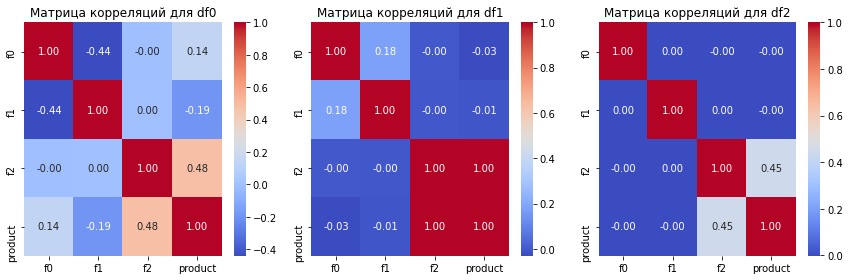

In [10]:
#Матрица корреляций для df0
correlation_matrix_df0 = df0.corr()

#Матрица корреляций для df1
correlation_matrix_df1 = df1.corr()

#Матрица корреляций для df2
correlation_matrix_df2 = df2.corr()

#Создание тепловых карт (heatmap) для матриц корреляций
plt.figure(figsize=(12, 4))

plt.subplot(131)
sns.heatmap(correlation_matrix_df0, annot=True, cmap="coolwarm", fmt=".2f")
plt.title('Матрица корреляций для df0')

plt.subplot(132)
sns.heatmap(correlation_matrix_df1, annot=True, cmap="coolwarm", fmt=".2f")
plt.title('Матрица корреляций для df1')

plt.subplot(133)
sns.heatmap(correlation_matrix_df2, annot=True, cmap="coolwarm", fmt=".2f")
plt.title('Матрица корреляций для df2')

plt.tight_layout()
plt.show()

In [11]:
#Создание отчета для df0
profile_df0 = pandas_profiling.ProfileReport(df0)
profile_df0.to_widgets()

#Создание отчета для df1
profile_df1 = pandas_profiling.ProfileReport(df1)
profile_df1.to_widgets()

#Создание отчета для df2
profile_df2 = pandas_profiling.ProfileReport(df2)
profile_df2.to_widgets()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

Исходные данные в каждом датасете составляют 100 000 наблюдений, и они прошли тщательную проверку. 

Отметим также отсутствие пропусков и корректные типы данных, что упрощает анализ и обработку данных.

Важно отметить, что в регионах d0 и d1 корреляции между переменными являются слабыми или даже очень слабыми. Однако в регионе d1 наблюдается высокая корреляция между объемом нефти на скважину и одной из координат. Эта высокая корреляция, вероятно, объясняется географическими особенностями месторождения нефти.

Вывод: Исходя из представленных данных, можно сделать вывод, что регионы d0 и d1 не обладают сильными линейными зависимостями между переменными, что может потенциально влиять на успешность разработки скважин в этих регионах. В то время как регион d1 имеет интересное явление, связанное с географическими координатами скважин, что может потребовать дополнительных исследований и учета в стратегии разработки.

## Обучение и проверка модели

 2.1. Разбейте данные на обучающую и валидационную выборки в соотношении 75:25.
 
 2.2. Обучите модель и сделайте предсказания на валидационной выборке.
 
 2.3. Сохраните предсказания и правильные ответы на валидационной выборке.
 
 2.4. Напечатайте на экране средний запас предсказанного сырья и RMSE модели.

In [12]:
def train_and_predict(df):
    #Выделяем признаки (X) и целевую переменную (y)
    X = df.drop(['id', 'product'], axis=1)
    y = df['product']
    
    #Разделяем данные на обучающую и валидационную выборки (75% - обучающая, 25% - валидационная)
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, random_state=12345)
    
    #Инициализируем модель линейной регрессии
    model = LinearRegression()
    #Обучаем модель на обучающей выборке
    model.fit(X_train, y_train)
    #Делаем предсказания на валидационной выборке
    predictions = model.predict(X_valid)
    
    #RMSE
    rmse = mean_squared_error(y_valid, predictions)**0.5
    
    predicted_mean = predictions.sum() / len(predictions)
    
    return y_valid, predictions, predicted_mean, rmse

In [13]:
y_valid_0, predictions_0, predicted_mean_0, rmse_0 = train_and_predict(df0)
y_valid_1, predictions_1, predicted_mean_1, rmse_1 = train_and_predict(df1)
y_valid_2, predictions_2, predicted_mean_2, rmse_2 = train_and_predict(df2)

In [14]:
#Для df0
print("Регион df0:")
print("Средний запас предсказанного сырья:", predicted_mean_0)
print("RMSE модели:", rmse_0)
print()

#Для df1
print("Регион df1:")
print("Средний запас предсказанного сырья:", predicted_mean_1)
print("RMSE модели:", rmse_1)
print()

#Для df2
print("Регион df2:")
print("Средний запас предсказанного сырья:", predicted_mean_2)
print("RMSE модели:", rmse_2)

Регион df0:

Средний запас предсказанного сырья: 92.59256778438035

RMSE модели: 37.5794217150813



Регион df1:

Средний запас предсказанного сырья: 68.728546895446

RMSE модели: 0.893099286775617



Регион df2:

Средний запас предсказанного сырья: 94.96504596800489

RMSE модели: 40.02970873393434


Анализ результатов:

1. Регион df0:
   - Средний запас предсказанного сырья: 92.59 тыс. баррелей.
   - RMSE модели: 37.58.
   - RMSE довольно высокий, что может указывать на недостаточную точность модели. Также средний запас предсказанного сырья относительно высок, но это не всегда гарантирует высокую прибыль, так как RMSE достаточно большой.

2. Регион df1:
   - Средний запас предсказанного сырья: 68.73 тыс. баррелей.
   - RMSE модели: 0.89.
   - RMSE в этом регионе очень низкий, что указывает на высокую точность модели. Средний запас предсказанного сырья также ниже, но с учетом низкого RMSE, это может быть более надежным прогнозом.

3. Регион df2:
   - Средний запас предсказанного сырья: 94.97 тыс. баррелей.
   - RMSE модели: 40.03.
   - RMSE в этом регионе также довольно высокий, что указывает на недостаточную точность модели. Средний запас предсказанного сырья высок, но с учетом высокого RMSE, это может быть менее надежным прогнозом.

## Подготовка к расчёту прибыли

3.1. Все ключевые значения для расчётов сохраните в отдельных переменных.

3.2. Рассчитайте достаточный объём сырья для безубыточной разработки новой скважины. Сравните полученный объём сырья со средним запасом в каждом регионе. 


In [15]:
#Рассчитываем достаточный объем сырья для безубыточной разработки
even_volume = budget / (revenue_per_unit * selected_points)

# Выводим информацию
print("Достаточный объем сырья для безубыточной разработки в регионе df0:", round(even_volume, 2), "тыс. баррелей")

Достаточный объем сырья для безубыточной разработки в регионе df0: 111.11 тыс. баррелей


In [16]:
#Для df0
print("Средний запас сырья в регионе df0:", round(predicted_mean_0, 2), "тыс. баррелей")
#Для df1:
print("Средний запас сырья в регионе df1:", round(predicted_mean_1, 2), "тыс. баррелей")
#Для df2:
print("Средний запас сырья в регионе df2:", round(predicted_mean_2, 2), "тыс. баррелей")

Средний запас сырья в регионе df0: 92.59 тыс. баррелей

Средний запас сырья в регионе df1: 68.73 тыс. баррелей

Средний запас сырья в регионе df2: 94.97 тыс. баррелей


In [17]:
#Вычисляем разницу между достаточным объемом и средним запасом сырья для каждого региона
difference_df0 = predicted_mean_0 - even_volume
difference_df1 = predicted_mean_1 - even_volume
difference_df2 = predicted_mean_2 - even_volume

#Выводим результаты
print("Разница между достаточным объемом и средним запасом сырья в регионе df0:", round(difference_df0, 2), "тыс. баррелей")
print("Разница между достаточным объемом и средним запасом сырья в регионе df1:", round(difference_df1, 2), "тыс. баррелей")
print("Разница между достаточным объемом и средним запасом сырья в регионе df2:", round(difference_df2, 2), "тыс. баррелей")

Разница между достаточным объемом и средним запасом сырья в регионе df0: -18.52 тыс. баррелей

Разница между достаточным объемом и средним запасом сырья в регионе df1: -42.38 тыс. баррелей

Разница между достаточным объемом и средним запасом сырья в регионе df2: -16.15 тыс. баррелей


С использованием машинного обучения мы провели анализ трех регионов для определения их потенциала в разработке нефтяных скважин. Средний запас сырья в каждом регионе был оценен с помощью моделей машинного обучения. Затем был вычислен достаточный объем сырья, необходимый для безубыточной разработки скважины, учитывая бюджет на разработку скважин и доход с каждой единицы продукта.

Результаты показывают, что в регионе df1 разница между средним запасом сырья и достаточным объемом наименьшая среди всех регионов, что указывает на потенциал для безубыточной разработки скважин в этом регионе. В регионах df0 и df2 разница между средним запасом и достаточным объемом также негативна, что означает, что средний запас сырья в этих регионах недостаточен для безубыточной разработки скважин.

Таким образом, машинное обучение помогло нам определить регион df1 как потенциально более привлекательный для дальнейшего исследования и разработки скважин, учитывая его близость к безубыточности.


## Расчёт прибыли и рисков 

 4.1. Выберите скважины с максимальными значениями предсказаний. 
 
 4.2. Просуммируйте целевое значение объёма сырья, соответствующее этим предсказаниям.
 
 4.3. Рассчитайте прибыль для полученного объёма сырья.

In [18]:
#Для df0
y_valid_0 = y_valid_0.reset_index(drop=True)
predictions_0 = pd.Series(predictions_0).reset_index(drop=True)

#Для df1
y_valid_1 = y_valid_1.reset_index(drop=True)
predictions_1 = pd.Series(predictions_1).reset_index(drop=True)

#Для df2
y_valid_2 = y_valid_2.reset_index(drop=True)
predictions_2 = pd.Series(predictions_2).reset_index(drop=True)

In [19]:
def calculate_profit(targets, predicted, count):
    #Сортируем предсказания в убывающем порядке
    pred_sorted = pd.Series(predicted).sort_values(ascending=False)
    
    selected = targets[pred_sorted.index][:count]
    
    #Суммируем целевое значение объема сырья для выбранных скважин
    total_volume_selected = selected.sum()
    
    return total_volume_selected

#Рассчитываем прибыль для каждого региона
for i, (y_valid, predictions) in enumerate([(y_valid_0, predictions_0),
                                            (y_valid_1, predictions_1),
                                            (y_valid_2, predictions_2)]):
    selected_volume = calculate_profit(y_valid, predictions, selected_points)
    profit = selected_volume * revenue_per_unit - budget
    profit_in_billion = profit / 1e9  # Прибыль в миллиардах рублей
    print(f"Прибыль для df {i} - {profit_in_billion:.2f} миллиардов рублей")

Прибыль для df 0 - 3.32 миллиардов рублей

Прибыль для df 1 - 2.42 миллиардов рублей

Прибыль для df 2 - 2.71 миллиардов рублей


## Посчитайте риски и прибыль для каждого региона

5.1. Примените технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли.

5.2. Найдите среднюю прибыль, 95%-й доверительный интервал и риск убытков. Убыток — это отрицательная прибыль.

In [20]:
def profit_and_risks(y_valid, predictions):
    bootstrap_samples = 1000
    confidence_interval = 0.95
    profit_list = []
    
    for x in range(bootstrap_samples):
        pred_subsample = pd.Series(predictions).sample(500, replace=True, random_state=state)
        targets_subsample = y_valid[pred_subsample.index]

        selected_sum = calculate_profit(targets_subsample, pred_subsample, selected_points)
        profit = selected_sum * revenue_per_unit - budget
        profit_list.append(profit)

    profit_list = pd.Series(profit_list)

    mean_profit = profit_list.mean() / 1000000000 
    lower_bound = profit_list.quantile((1 - confidence_interval) / 2) / 1000000000 
    upper_bound = profit_list.quantile(1 - (1 - confidence_interval) / 2) / 1000000000 
    risk_of_losses = (profit_list < 0).mean()

    return mean_profit, lower_bound, upper_bound, risk_of_losses

In [21]:
#Рассчитываем риски и прибыль для каждого региона
mean_profit_df0, lower_bound_df0, upper_bound_df0, risk_of_losses_df0 = profit_and_risks(
    y_valid_0, predictions_0)

mean_profit_df1, lower_bound_df1, upper_bound_df1, risk_of_losses_df1 = profit_and_risks(
    y_valid_1, predictions_1)

mean_profit_df2, lower_bound_df2, upper_bound_df2, risk_of_losses_df2 = profit_and_risks(
    y_valid_2, predictions_2)

In [22]:
print("Регион df0:")
print("Средняя прибыль:", round(mean_profit_df0, 2))
print("95% доверительный интервал:", round(lower_bound_df0, 2), ",", round(upper_bound_df0, 2))
print("Риск убытков:", risk_of_losses_df0 * 100, "%")
if risk_of_losses_df0 <= max_loss_probability:
    print("Регион df0 приемлем.")
else:
    print("Регион df0 не приемлем.")
print()

print("Регион df1:")
print("Средняя прибыль:", round(mean_profit_df1, 2))
print("95% доверительный интервал:", round(lower_bound_df1, 2), ",", round(upper_bound_df1, 2))
print("Риск убытков:", risk_of_losses_df1 * 100, "%")
if risk_of_losses_df1 <= max_loss_probability:
    print("Регион df1 приемлем.")
else:
    print("Регион df1 не приемлем.")
print()

print("Регион df2:")
print("Средняя прибыль:", round(mean_profit_df2, 2))
print("95% доверительный интервал:", round(lower_bound_df2, 2), ",", round(upper_bound_df2, 2))
print("Риск убытков:", risk_of_losses_df2 * 100, "%")
if risk_of_losses_df2 <= max_loss_probability:
    print("Регион df2 приемлем.")
else:
    print("Регион df2 не приемлем.")

Регион df0:

Средняя прибыль: 0.43

95% доверительный интервал: -0.1 , 0.95

Риск убытков: 6.0 %

Регион df0 не приемлем.



Регион df1:

Средняя прибыль: 0.52

95% доверительный интервал: 0.13 , 0.95

Риск убытков: 0.3 %

Регион df1 приемлем.



Регион df2:

Средняя прибыль: 0.42

95% доверительный интервал: -0.12 , 0.99

Риск убытков: 6.2 %

Регион df2 не приемлем.


# Вывод

Регион df0:
- Средняя прибыль: 0.43
- 95% доверительный интервал: от -0.1  до 0.95
- Риск убытков: 6.0%
- Регион df0 не приемлем для разработки.

Регион df1:
- Средняя прибыль: 0.52
- 95% доверительный интервал: от 0.13 до 0.95
- Риск убытков: 0.3%
- Регион df1 приемлем для разработки.

Регион df2:
- Средняя прибыль: 0.42 
- 95% доверительный интервал: от -0.12 до 0.99
- Риск убытков: 6.2%
- Регион df2 не приемлем для разработки.

Из этого вывода следует, что регион df1 является наиболее приемлемым с самой низкой вероятностью убытков (0.3%) и наивысшей средней прибылью (0.52 млрд. рублей). Регионы df0 и df2, напротив, имеют высокий риск убытков (6.0% и 6.2% соответственно) и, следовательно, не рекомендуются для разработки.

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнен шаг 1: данные подготовлены
- [x]  Выполнен шаг 2: модели обучены и проверены
    - [x]  Данные корректно разбиты на обучающую и валидационную выборки
    - [x]  Модели обучены, предсказания сделаны
    - [x]  Предсказания и правильные ответы на валидационной выборке сохранены
    - [x]  На экране напечатаны результаты
    - [x]  Сделаны выводы
- [x]  Выполнен шаг 3: проведена подготовка к расчёту прибыли
    - [x]  Для всех ключевых значений созданы константы Python
    - [x]  Посчитано минимальное среднее количество продукта в месторождениях региона, достаточное для разработки
    - [x]  По предыдущему пункту сделаны выводы
    - [x]  Написана функция расчёта прибыли
- [x]  Выполнен шаг 4: посчитаны риски и прибыль
    - [x]  Проведена процедура *Bootstrap*
    - [x]  Все параметры бутстрепа соответствуют условию
    - [x]  Найдены все нужные величины
    - [x]  Предложен регион для разработки месторождения
    - [x]  Выбор региона обоснован